In [64]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation as LDA   
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

from time import time
from wordcloud import WordCloud

In [2]:
# Import dataset
df = pd.read_csv('data/preprocessed_data.csv')

# Train-Test Split

In [3]:
# Remove stopwords
stop = stopwords.words('english')

# Include other words that occur frequently
newStopWords = ['blush','nars','orgasm','colour','color']
stop.extend(newStopWords)

df['review_processed_stop'] = df['review_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [4]:
X = df.drop(['repurchase_again','date','review_length'], axis=1)
y = df['repurchase_again']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# create dictionary which maps each token to its corresponding tf-idf score to get more domain specific stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words=stop)
X_train_dtm = vect.fit_transform(X_train['review_processed_stop'])
word2tfidf = dict(zip(vect.get_feature_names(), vect.idf_))
domain_specific_stopwords = sorted(word2tfidf, key = word2tfidf.get)[:40]

In [6]:
domain_specific_stopwords

['look',
 'skin',
 'like',
 'love',
 'would',
 'pink',
 'really',
 'wa',
 'shimmer',
 'one',
 'give',
 'much',
 'product',
 'use',
 'cheek',
 'natural',
 'think',
 'great',
 'doe',
 'get',
 'glow',
 'go',
 'pretty',
 'ha',
 'pigmented',
 'little',
 'make',
 'light',
 'tone',
 'last',
 'time',
 'peachy',
 'day',
 'good',
 'well',
 'nice',
 'beautiful',
 'brush',
 'perfect',
 'face']

In [7]:
# Exclude stopwords that could help in determining if one will repurchase
domain_specific_stopwords = list(filter(lambda x: x not in ['like', 'love', 'great', 'pretty', 'good', 'beautiful', 'nice', 'perfect'], domain_specific_stopwords))

# Include more domain specific stop words
stop.extend(domain_specific_stopwords)

In [8]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lda', LDA(learning_method='online', learning_offset=50., random_state=0)),
])

# Define parameters to tune
parameters = {
    'vect__use_idf': (True, False),
    'vect__max_df': (0.85, 0.9, 0.95),
    'vect__min_df': (0.01, 0.03, 0.05),
    'vect__stop_words': (None, stop, 'english'),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'lda__n_components': (3, 4, 5, 6),
    'lda__learning_decay': (.5, .7, .9),
    'lda__max_iter': (5,10,50,100)
}

lda_randomsearch = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5, n_jobs=-1, verbose=1, random_state=0,return_train_score=True)

#t0 = time()

# Do the Randomized Search
lda_randomsearch.fit(X_train['review_processed'])

#print("done in %0.3fs" % (time() - t0))
print("Best Model's Params: ", lda_randomsearch.best_params_)
print("Best Log Likelihood Score: ", lda_randomsearch.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model's Params:  {'vect__use_idf': True, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'a

In [9]:
# Save to file
joblib.dump(lda_randomsearch, 'models/lda_randomsearch.pkl')

['models/lda_randomsearch.pkl']

In [8]:
# Load file
lda_randomsearch = joblib.load('models/lda_randomsearch.pkl')

In [9]:
# Using best estimator for tf-idf vectorizer to do topic modeling
tfidf_vectorizer = lda_randomsearch.best_estimator_[0]
X_train_dtm = tfidf_vectorizer.transform(X_train['review_processed'])
X_test_dtm = tfidf_vectorizer.transform(X_test['review_processed'])

In [10]:
X_train_dtm.shape

(5029, 123)

In [11]:
# Using best estimator for LDA model to do topic modeling
best_lda_model = lda_randomsearch.best_estimator_[1]
X_train_LDA = best_lda_model.transform(X_train_dtm)
X_test_LDA = best_lda_model.transform(X_test_dtm)

# Column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

In [12]:
### Train Data ###

# index names
docnames_train = ["TrainDoc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic_train = pd.DataFrame(np.round(X_train_LDA, 2), columns=topicnames, index=docnames_train)

# Get dominant topic for each document
dominant_topic_train = np.argmax(df_document_topic_train.values, axis=1)
df_document_topic_train['dominant_topic'] = dominant_topic_train
print(df_document_topic_train.head())
print('\nDistribution of topics')
print(df_document_topic_train['dominant_topic'] .value_counts())

           Topic0  Topic1  Topic2  Topic3  dominant_topic
TrainDoc0    0.08    0.46    0.39    0.08               1
TrainDoc1    0.20    0.07    0.06    0.67               3
TrainDoc2    0.60    0.14    0.13    0.13               0
TrainDoc3    0.25    0.25    0.25    0.25               0
TrainDoc4    0.82    0.06    0.06    0.06               0

Distribution of topics
3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64


In [13]:
### Test Data

# index names
docnames_test = ["TestDoc" + str(i) for i in range(len(X_test))]

# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(X_test_LDA, 2), columns=topicnames, index=docnames_test)

# Get dominant topic for each document
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test['dominant_topic'] = dominant_topic_test
print(df_document_topic_test.head())
print('\nDistribution of topics')
print(df_document_topic_test['dominant_topic'] .value_counts())

          Topic0  Topic1  Topic2  Topic3  dominant_topic
TestDoc0    0.43    0.05    0.05    0.47               3
TestDoc1    0.06    0.06    0.06    0.82               3
TestDoc2    0.06    0.06    0.06    0.81               3
TestDoc3    0.18    0.13    0.20    0.49               3
TestDoc4    0.11    0.11    0.11    0.67               3

Distribution of topics
3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64


In [14]:
from sklearn.decomposition import TruncatedSVD
clusters = dominant_topic_train
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X_train_LDA)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

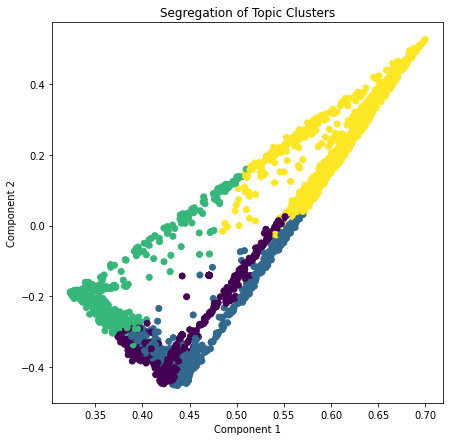

In [15]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

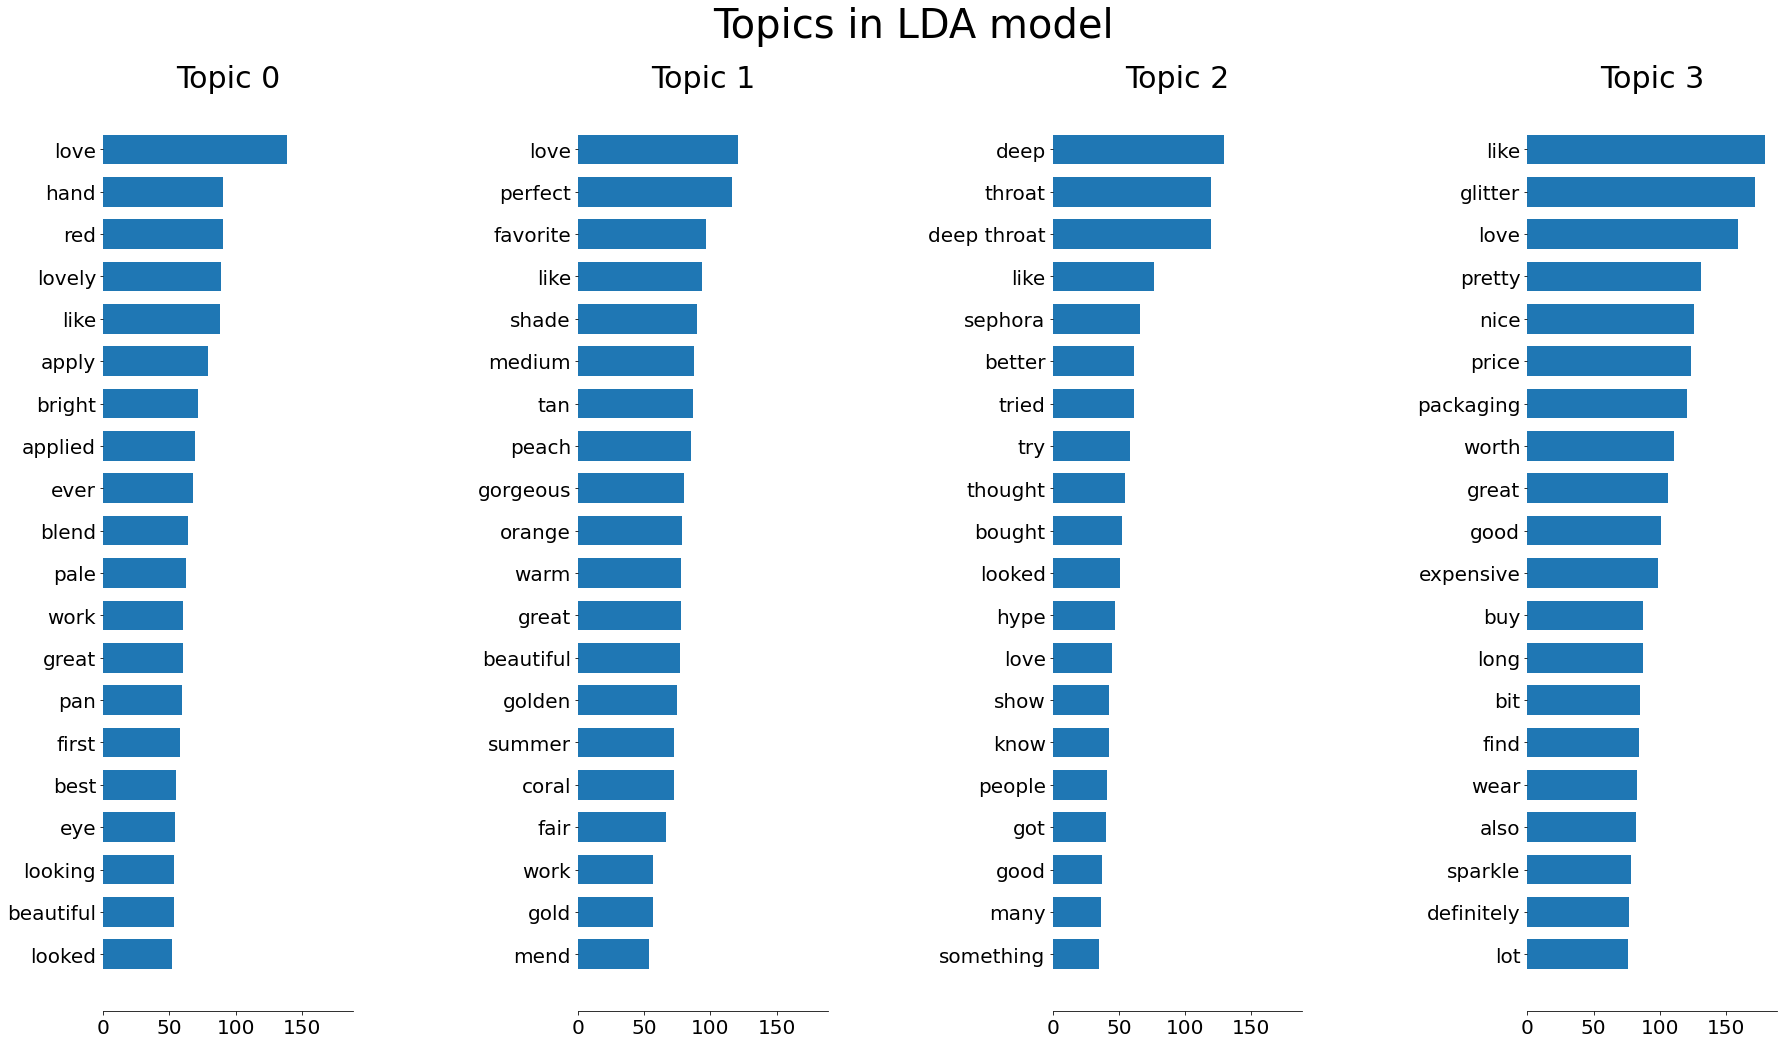

In [16]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
words = tfidf_vectorizer.get_feature_names()
plot_top_words(best_lda_model, words, n_top_words, 'Topics in LDA model')

In [17]:
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [18]:
# Add topic feature into products
X_train['dominant_topic'] = dominant_topic_train
X_test['dominant_topic'] = dominant_topic_test

In [19]:
X_train['dominant_topic'].value_counts()

3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64

In [20]:
X_test['dominant_topic'].value_counts()

3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64

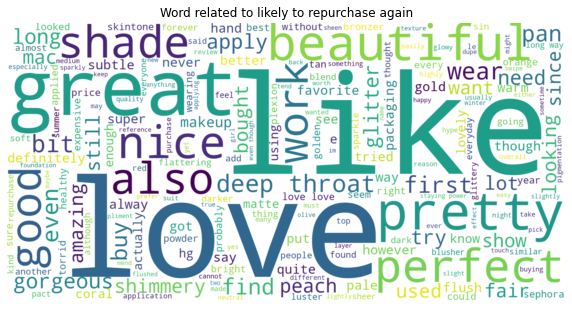

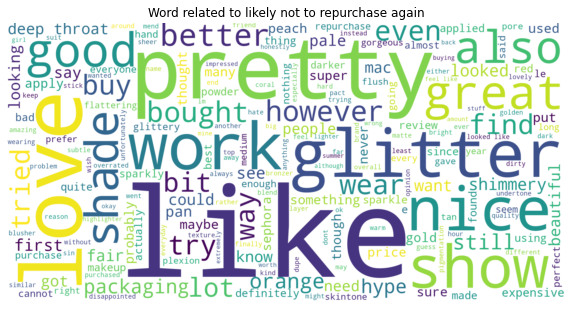

In [21]:
# Wordcloud
repurchase_products = df[df['repurchase_again'] == 1]
donot_repurchase_products = df[df['repurchase_again'] == 0]
repurchase_reviews = " ".join(r for r in repurchase_products['review_processed_stop'])
donot_repurchase_reviews = " ".join(r for r in donot_repurchase_products['review_processed_stop'])

# Create and generate a word cloud image that excludes domain-specific and common stopwords
repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(repurchase_reviews)
donot_repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(donot_repurchase_reviews)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely to repurchase again")
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(donot_repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely not to repurchase again")
plt.show()

# Model Building

In [22]:
# Check class distribution
y_train.value_counts()

1    3811
0    1218
Name: repurchase_again, dtype: int64

In [23]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return x.drop(['review','review_processed','review_processed_stop'],axis=1)

def get_text_data(x):
    return x['review_processed']

transformer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [25]:
# Training config
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = {'Recall': 'recall', 'Precision': 'precision', 'ROC_AUC': 'roc_auc', 'F1': 'f1_macro'}
refit = 'F1'

## Logistic Regression

In [26]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('logreg', LogisticRegression(solver='liblinear', random_state=0))
])

# Randomized Search Parameters for Log Reg
param_grid = {
              'features__text_features__vect__use_idf': (True, False),
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'logreg__C': (0.01, 1, 10),
              'logreg__penalty': ('l1', 'l2'),
             }


# Perform Randomized Search
logreg = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
logreg.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000002677AE21EA0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       'his',
                                                    

In [39]:
# Check the best params chosen
logreg.best_params_

{'logreg__penalty': 'l2',
 'logreg__C': 10,
 'features__text_features__vect__use_idf': False,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 1.0}

In [98]:
# Save to file
joblib.dump(logreg, 'models/logreg.pkl')

['models/logreg.pkl']

In [25]:
# Load file
logreg = joblib.load('models/logreg.pkl')

In [81]:
# Number of words from TFIDF Vectorizer
len(logreg.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1735

In [89]:
# Number of features chosen
np.sum(logreg.best_estimator_['feature_selection'].get_support())

395

In [88]:
# Total number of features
len(logreg.best_estimator_['feature_selection'].get_support())

1764

In [27]:
# Model prediction
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)[:, 1]

In [65]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Precision:', precision_score(y_test, y_pred_logreg))
print('Recall:', recall_score(y_test, y_pred_logreg))
print('F1:', f1_score(y_test, y_pred_logreg, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_logreg_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_logreg))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.8586762075134168
Precision: 0.8789667896678967
Recall: 0.942246835443038
F1: 0.7935292329990415
ROC_AUC: 0.9098484384099058

Confusion Matrix:
[[ 249  164]
 [  73 1191]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.60      0.68       413
           1       0.88      0.94      0.91      1264

    accuracy                           0.86      1677
   macro avg       0.83      0.77      0.79      1677
weighted avg       0.85      0.86      0.85      1677



## SVM

In [29]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('svm', SVC(probability=True, random_state=0))
])

# Randomized Search Parameters for SVM
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'svm__C': (0.1, 1, 10), 
              'svm__gamma': (1, 0.1, 0.01),
              'svm__kernel': ('linear', 'rbf', 'poly', 'sigmoid')
             }


# Perform Randomized Search
svm = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
svm.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000002677AE21EA0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       'he',
                                                     

In [40]:
# Check the best params chosen
svm.best_params_

{'svm__kernel': 'rbf',
 'svm__gamma': 1,
 'svm__C': 10,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 0.75}

In [99]:
# Save to file
joblib.dump(svm, 'models/svm.pkl')

['models/svm.pkl']

In [28]:
# Load file
svm = joblib.load('models/svm.pkl')

In [90]:
# Number of words from TFIDF Vectorizer
len(svm.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1729

In [91]:
# Number of features chosen
np.sum(svm.best_estimator_['feature_selection'].get_support())

415

In [92]:
# Total number of features
len(svm.best_estimator_['feature_selection'].get_support())

1758

In [30]:
# Model prediction
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

In [66]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))
print('F1:', f1_score(y_test, y_pred_svm, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_svm_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.8425760286225402
Precision: 0.8644314868804664
Recall: 0.9382911392405063
F1: 0.766080116323796
ROC_AUC: 0.8802094507616391

Confusion Matrix:
[[ 227  186]
 [  78 1186]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.86      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.74      0.77      1677
weighted avg       0.83      0.84      0.83      1677



## Naive Bayes

In [32]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('nb', MultinomialNB())
])

# Randomized Search Parameters for Naive Bayes
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'nb__alpha': (0.0001, 0.01, 1, 10)
             }


# Perform Randomized Search
nb = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
nb.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000002677AE21EA0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       "you've",
                                                 

In [41]:
# Check the best params chosen
nb.best_params_

{'nb__alpha': 0.01,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 0.5}

In [100]:
# Save to file
joblib.dump(nb, 'models/nb.pkl')

['models/nb.pkl']

In [31]:
# Load file
nb = joblib.load('models/nb.pkl')

In [93]:
# Number of words from TFIDF Vectorizer
len(nb.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1718

In [94]:
# Number of features chosen
np.sum(nb.best_estimator_['feature_selection'].get_support())

429

In [95]:
# Total number of features
len(nb.best_estimator_['feature_selection'].get_support())

1747

In [33]:
# Model prediction
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]

In [67]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Precision:', precision_score(y_test, y_pred_nb))
print('Recall:', recall_score(y_test, y_pred_nb))
print('F1:', f1_score(y_test, y_pred_nb, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_nb_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_nb))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.8264758497316637
Precision: 0.8241172551632245
Recall: 0.9786392405063291
F1: 0.7003490760384015
ROC_AUC: 0.859361111962485

Confusion Matrix:
[[ 149  264]
 [  27 1237]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.36      0.51       413
           1       0.82      0.98      0.89      1264

    accuracy                           0.83      1677
   macro avg       0.84      0.67      0.70      1677
weighted avg       0.83      0.83      0.80      1677



# Stacking

In [56]:
from mlxtend.classifier import StackingClassifier
sclf = StackingClassifier(classifiers=[logreg, svm, nb], 
                          meta_classifier=LogisticRegression(), fit_base_estimators=False)

sclf.fit(X_train, y_train)

C:\Users\carin\AppData\Local\Programs\Python\Python37\lib\site-packages\mlxtend\classifier\stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


StackingClassifier(classifiers=[RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                                                   estimator=Pipeline(steps=[('features',
                                                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                                                              Pipeline(steps=[('selector',
                                                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000002677AE21EA0>))])),
                                                                                                             ('text_features',
                                                                                                              Pipeline(steps=[('selector',
                                                      

In [57]:
# Model prediction
y_pred_sclf = sclf.predict(X_test)
y_pred_sclf_proba = sclf.predict_proba(X_test)[:, 1]

In [68]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_sclf))
print('Precision:', precision_score(y_test, y_pred_sclf))
print('Recall:', recall_score(y_test, y_pred_sclf))
print('F1:', f1_score(y_test, y_pred_sclf, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_sclf_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_sclf))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_sclf))

Accuracy: 0.8425760286225402
Precision: 0.8644314868804664
Recall: 0.9382911392405063
F1: 0.766080116323796
ROC_AUC: 0.8149500413767738

Confusion Matrix:
[[ 227  186]
 [  78 1186]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.86      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.74      0.77      1677
weighted avg       0.83      0.84      0.83      1677



# Stacking with tuning

In [59]:
# Predictions for train datasets and convert to dataframe
y_pred_logreg_train = pd.DataFrame(logreg.predict(X_train))
y_pred_svm_train = pd.DataFrame(svm.predict(X_train))
y_pred_nb_train = pd.DataFrame(nb.predict(X_train))

# Convert test datasets into dataframe
y_pred_logreg = pd.DataFrame(y_pred_logreg)
y_pred_svm = pd.DataFrame(y_pred_svm)
y_pred_nb = pd.DataFrame(y_pred_nb)

In [60]:
# Concatenate the predictions for both train and test datasets for all 3 models
df_train = pd.concat([y_pred_logreg_train, y_pred_svm_train, y_pred_nb_train],axis=1)
df_test = pd.concat([y_pred_logreg, y_pred_svm, y_pred_nb], axis=1)

In [61]:
from sklearn.model_selection import GridSearchCV
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('logreg', LogisticRegression(solver='liblinear', random_state=0))
])

# Randomized Search Parameters for Log Reg
param_grid = {
              'logreg__C': (0.01, 1, 10),
              'logreg__penalty': ('l1', 'l2'),
             }


# Perform Grid Search
stack_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, return_train_score=True)

stack_model.fit(df_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': (0.01, 1, 10),
                         'logreg__penalty': ('l1', 'l2')},
             refit='F1', return_train_score=True,
             scoring={'F1': 'f1_macro', 'Precision': 'precision',
                      'ROC_AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=1)

In [62]:
y_pred_stack = stack_model.predict(df_test)
y_pred_stack_proba = stack_model.predict_proba(df_test)[:, 1]

In [69]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_stack))
print('Precision:', precision_score(y_test, y_pred_stack))
print('Recall:', recall_score(y_test, y_pred_stack))
print('F1:', f1_score(y_test, y_pred_stack, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_stack_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_stack))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_stack))

Accuracy: 0.8425760286225402
Precision: 0.8644314868804664
Recall: 0.9382911392405063
F1: 0.766080116323796
ROC_AUC: 0.7439639715572991

Confusion Matrix:
[[ 227  186]
 [  78 1186]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.86      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.74      0.77      1677
weighted avg       0.83      0.84      0.83      1677



In [101]:
# Save to file
joblib.dump(stack_model, 'models/stack_model.pkl')

['models/stack_model.pkl']